In [6]:
## Include packages

using DelimitedFiles
using DCAUtils
using Plots
using KitMSA
using FastaIO
using Statistics
using StatsBase
using LinearAlgebra


include("../src/read_write.jl")
include("../src/energy.jl")
include("../src/msa_tools.jl")
include("../src/extra_tools.jl")
;

In [4]:
PATH_PAR = "../data/model_parameters/Parameters_conv_Matteo_pc.dat" #to unzip
h, J = KitMSA.extract_params(PATH_PAR;q=21)
;

LoadError: Error: the file "../data/model_parameters/Parameters_conv_Matteo_pc.dat" does not exist. Please check the spelling or the folder path.

In [5]:
function compare_seq(a::Array{Int8,1}, b::Array{Int8,1})
    if a == b
        return 0
    else
        return findall(a .!= b)[1]
    end
end

function find_positions(msa)
    
    return [compare_seq(msa[j-1,:], msa[j,:]) for j in 2:length(msa[:,1])]
        
end


function mut_effect_WTtoB_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, b)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = b
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end


function mut_effect_WTtoA_one_seq(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq, mut_s, a)
    
    seq_pre = deepcopy(seq)
    seq_post = deepcopy(seq)
    
    seq_post[mut_s] = a
    
    return delta_energy(h,J, seq_post, seq_pre)
    
end

   
function cont_entr_over_time(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_t, mut_s, a, b, window)
    
    res = Array{Float64}(undef,2*window+1)
    idx = 0
    for i in mut_t-window:mut_t
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoB_one_seq(h, J, seq_chain[i,:], mut_s, b)
        end
    end

    for i in mut_t+1:mut_t+window
        idx+=1
        
        if seq_chain[i,:] == seq_chain[i-1,:] 
            #println("no mut")
            if idx !=1
                res[idx] = res[idx-1]
            end
        else        
            res[idx] = mut_effect_WTtoA_one_seq(h, J, seq_chain[i,:], mut_s, a)
        end
    end

    return res
end

function cont_entr_setofmuts(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, n_muts, start_t,window)
    res = Array{Float64}(undef, n_muts, 2*window+1)
    for i in 1:n_muts
        res[i,:] = cont_entr_over_time(h, J, 
            seq_chain, mut_times[start_t+i], mut_sites[start_t+i], 
            a[start_t+i], b[start_t+i], window)
    end
    return res
end

function cont_entr_setofmuts_eachstep(h::Array{Float64,2}, J::Array{Float64,4}, 
        seq_chain::Array{Int8,2}, mut_times::Array{Int64,1}, 
        mut_sites::Array{Int64,1}, a, b, window, mut_range)
    res = Array{Float64}(undef, length(mut_range), 2*window+1)
    idx = 0
    for i in mut_range
        idx +=1
        res[idx,:] = cont_entr_over_time(h, J, seq_chain, mut_times[i], mut_sites[i], 
            a[i], b[i], window)
    end
    return res
end

function get_entropy(f)
    N=length(f[1,:])
    entr = zeros(Float64, N)
    for i in 1:N
        for a in 1:20
            if(f[a,i]>0)
                entr[i]-=f[a,i]*log(f[a,i])
            end
        end
    end
    
    return entr
end

function cont_dep_entr_without_deg(background, h, J)
    
    T = 1.0
    N = length(background)
    
    prob = hcat([ProbabilityWeights(proba_DNA_gibbs_without_deg(pos_mut, background, h, J, N, T)) for pos_mut in 1:N]...)
    #println(size(prob))
    return get_entropy(prob)[:]
end

function proba_DNA_gibbs_without_deg(k, mutated_seq, h, J,N,  T = 1)
	prob = zeros(20)
	for i in 1:20
        q_k = i
		log_proba = h[q_k, k]
 		for j in 1:N
			log_proba += J[mutated_seq[j], q_k , j, k]
		end
		prob[i] = exp(log_proba/T)
	end
	return normalize(prob,1)
    
end


function cde_1site(site, background, h, J)
    T = 1.0
    N = length(background)
    prob = ProbabilityWeights(proba_DNA_gibbs_without_deg(site, 
            background, h, J, N, T))
    return get_entropy(prob)
end

cde_1site (generic function with 1 method)

In [5]:
path_wt_pse = "../data/alignments/refs/wt_DNA/PSE1_pfam_DNA.fasta"

#load wt
wt_pse = join(readdlm(path_wt_pse, skipstart = 1))
L_pse = Int64(length(wt_pse)/3)
pse_DNA_seq = [wt_pse[((i-1)*3 +1):(i*3)] for i in 1:L_pse]
pse_amino_seq = [cod2amino[codon] for codon in pse_DNA_seq]
path_beta = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_beta = Int8.(fasta2matrix(path_beta))
path_nat = "../data/alignments/natural/PF13354_noinsert_max19gaps_nodupl_noclose.faa"
nat_MSA = Int8.(fasta2matrix(path_nat))
path_dbd = "../data/alignments/natural/DBD_alignment.uniref90.cov80.a2m"
nat_dbd = Int8.(fasta2matrix(path_dbd))
;

In [6]:
folder_path = "../data/chains/equil_det_bal_pse_silico_chain_num_1_T_1.0.mixedDNA" #to unzip
@time matrices = Int8.(fasta2matrix(folder_path))
@time pos = find_positions(matrices)
mut_times = [i for (i, val) in enumerate(pos) if val != 0]
mut_sites = [val for val in pos if val != 0]
;

 10.130504 seconds (3.60 M allocations: 832.628 MiB, 2.57% gc time)
  6.515623 seconds (1.67 M allocations: 328.513 MiB, 18.59% compilation time)


In [7]:
CDE_nat = readdlm("../data/figures/data_fig2/cde_NAT", '\t')
;

In [8]:
m_cde_nat = mean(CDE_nat, dims = 1)[:]
st_cde_nat = std(CDE_nat, dims = 1)[:]
;

In [9]:
L = length(pse_amino_seq)
freqs_nat = reshape(compute_weighted_frequencies(Int8.(nat_MSA'), 0.2)[1], (20, L))
entr_nat = get_entropy(freqs_nat)
;

θ = 0.2 threshold = 40.0
M = 18334 N = 202 Meff = 6875.804074759526


In [10]:
using DataFrames


a = []
b = []
c = []
d = []
e = []
f = []
for i in 1:length(mut_times)
    push!(a, matrices[mut_times[i], mut_sites[i]])
    push!(b, matrices[mut_times[i]+1, mut_sites[i]])
    push!(c, cde_1site(mut_sites[i], matrices[mut_times[i]], h, J)[1] / log(2))
    push!(d, m_cde_nat[mut_sites[i]] /log(2))
    push!(e, st_cde_nat[mut_sites[i]] /log(2))
    push!(f, entr_nat[mut_sites[i]] /log(2))
    
end
 
# Create a DataFrame from the lists
data = DataFrame(site_i = mut_sites, amino_a = a, amino_b = b, time = mut_times,
    cde_local = c, cde_global = d, st_cde_global = e, cie = f )
;

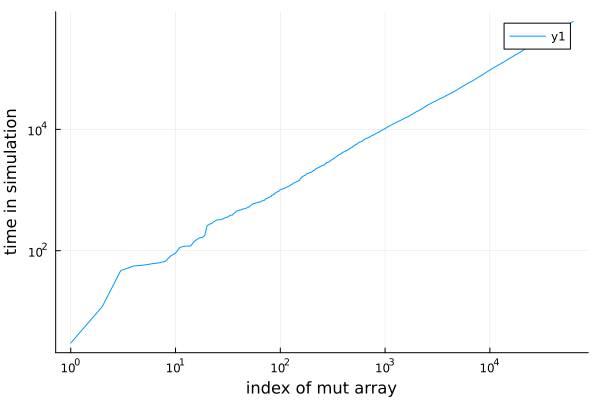

In [11]:
plot(data[:,4], xlabel= "index of mut array", 
    ylabel="time in simulation", xscale =:log10, yscale =:log10)

In [14]:
start_t = 20000
n_muts = 5000
lag = 3
window = 5000
each_step = start_t:lag:(start_t-1)+(lag*n_muts)
println(length(each_step))
println(each_step)


@time y = cont_entr_setofmuts_eachstep(h, J, matrices, mut_times, 
    mut_sites, data[:,2], data[:,3], window, each_step)
;

5000
20000:3:34997
168.472304 seconds (167.30 M allocations: 51.117 GiB, 13.06% gc time)


In [15]:
mut_data = data[each_step,:]
using CSV
CSV.write("../data/figures/data_fig3/cont_entr_df.csv", mut_data)
;

In [16]:
x = 2:window-49
cont = y[:, 50:window-1]
entren = y[:, window+2:end-50]
;

In [17]:
@time writedlm("../data/figures/data_fig3/cont", cont)

 56.896370 seconds (49.54 M allocations: 10.336 GiB, 8.41% gc time, 0.87% compilation time)


In [18]:
@time writedlm("../data/figures/data_fig3/entren", entren)

 37.892348 seconds (49.51 M allocations: 10.333 GiB, 10.35% gc time)


In [19]:
@time writedlm("../data/figures/data_fig3/x_steps", x)

  0.164062 seconds (37.32 k allocations: 2.365 MiB, 76.05% compilation time)
